In [1]:
!nvidia-smi

Wed Jul 12 15:27:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq bitsandbytes==0.39.0
!pip install -qqq torch--2.0.1 --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71 --progress-bar off
!pip install -qqq loralib==0.1.1 --progress-bar off
!pip install einops

ERROR: Could not find a version that satisfies the requirement torch--2.0.1 (from versions: none)
ERROR: No matching distribution found for torch--2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00


In [3]:
import os
from pprint import pprint
import json

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 6.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/cuda/lib'), PosixPath('/usr/local/lib/x86_64-linux-gnu'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_tra

In [4]:
MODEL_NAME = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model =AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [6]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [7]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4718592 || all params: 3613463424 || trainable%: 0.13058363808693696


In [8]:
df = pd.read_json("/kaggle/input/aibe-mcq/new_100_questions.json")

In [9]:
df["Question"][0]

'1. How many kinds of presumptions are there as classified by the Supreme Court?'

In [10]:
df["Options"][0]

['a) Permissive presumptions or presumptions of facts',
 'b) Compelling presumptions or presumptions of law (rebuttable presumptions)',
 'c) Irrebuttable presumptions of law or conclusive presumptions.',
 'd) All of them']

In [12]:
generation_config = model.generation_config
generation_config.max_new_tokens = 256
generation_config.temperature = 1
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

device = "cuda:0"

In [13]:
generation_config

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 11,
  "max_new_tokens": 256,
  "pad_token_id": 11,
  "top_p": 0.7,
  "transformers_version": "4.30.0.dev0"
}

In [14]:
for i in range(0,1):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"] = last_line

In [15]:
df.head(1)

,Question,Options,Unprompted_prediction
0,1. How many kinds of presumptions are there as...,[a) Permissive presumptions or presumptions of...,Answer: 'a) Permissive presumptions or presump...


In [16]:
%%time
for i in range(1,6):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"][i] = last_line

CPU times: user 28 s, sys: 0 ns, total: 28 s
Wall time: 28 s


In [17]:
df.head(6)

,Question,Options,Unprompted_prediction
0,1. How many kinds of presumptions are there as...,[a) Permissive presumptions or presumptions of...,Answer: 'a) Permissive presumptions or presump...
1,2. What is the leading decision in the case of...,"[a) Right of hearing, b) Separation of powers,...",c) Delegated legislation
2,3. Advocate's act 1961 came into force on:,"[a) 19th May, 1961, b) 19th April, 1961, c) 1s...","a) 19th May, 1961"
3,4. Harbouring an offender who has escaped from...,"[a) Section 215 of IPC, b) Section 216 of IPC,...",a) Section 215 of IPC
4,5. The maxim 'actus not facit reum nisi mens s...,[a) There can be no crime without a guilty min...,d
5,6. Law laid down under section -73 of Indian C...,"[a) Hothester Vs De-la-tur, b) Rabinson Vs Dev...",a) Hothester Vs De-la-tur


In [18]:
%%time
for i in range(6,26):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"][i] = last_line

CPU times: user 3min 7s, sys: 0 ns, total: 3min 7s
Wall time: 3min 7s


In [19]:
%%time
for i in range(26,56):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"][i] = last_line

CPU times: user 3min 6s, sys: 0 ns, total: 3min 6s
Wall time: 3min 7s


In [20]:
%%time
for i in range(56,86):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"][i] = last_line

CPU times: user 9min 9s, sys: 288 ms, total: 9min 9s
Wall time: 9min 10s


In [21]:
%%time
for i in range(86,100):
    prompt = "Question " + df["Question"][i] + "\n" + "Options " + str(df["Options"][i])
    prompt.strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids=encoding.input_ids,
          attention_mask=encoding.attention_mask,
          generation_config=generation_config,
      )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)
    last_line = response.splitlines()[-1]
    df["Unprompted_prediction"][i] = last_line

CPU times: user 1min 13s, sys: 44 ms, total: 1min 13s
Wall time: 1min 13s


In [22]:
df["Unprompted_prediction"].to_list()

["Answer: 'a) Permissive presumptions or presumptions of fact'",
 'c) Delegated legislation',
 'a) 19th May, 1961',
 'a) Section 215 of IPC',
 'd',
 'a) Hothester Vs De-la-tur',
 'a) Does not permit any party to that',
 "Answer: 'c) Cognizable and non-bailable'",
 'a) 60%',
 'a) 25 %',
 'a) Body',
 "Answer: 'c) The examination of witness in absence of the accused'",
 "Answer: 'c) the court originally trying the case can order de nova trial'",
 'c) Article 22',
 'a) 44th Amendment Act',
 'a) Section 4',
 'd) Either under (a) OR under (b)',
 'a) sexual assault',
 'a) Tweedle Vs Atkinson',
 "Answer: 'c) Sec. 2(d)",
 'd) List of injuries Deemed to Result in Permanent Total Disablement',
 'a) Section 7',
 'a) Change of life',
 "Question 24. A plaint has to be presented to the Court under Order IV, Rule 1 in ['a) Single copy ', 'b) Duplicate ', 'c) Triplicate ', 'd) No fixed rule ']",
 'a) Render the execution null and void',
 'a) 3 months from the date of the decree',
 'a) Clause (1) (E)',


In [23]:
# Save the DataFrame to a CSV file
df.to_csv('AIBE_XV_v2_output.csv', index=False)

In [24]:
question_list = df["Question"].to_list()

In [25]:
# Initialize variables
total_length = 0
total_words = 0

# Iterate over each string in the list
for string in question_list:
    # Split the string into words
    words = string.split()
    
    # Iterate over each word
    for word in words:
        total_length += len(word)
        total_words += 1

# Calculate average word length
average_length = total_length / total_words

# Print the average word length
print("Average word length:", average_length)


Average word length: 4.766137566137566


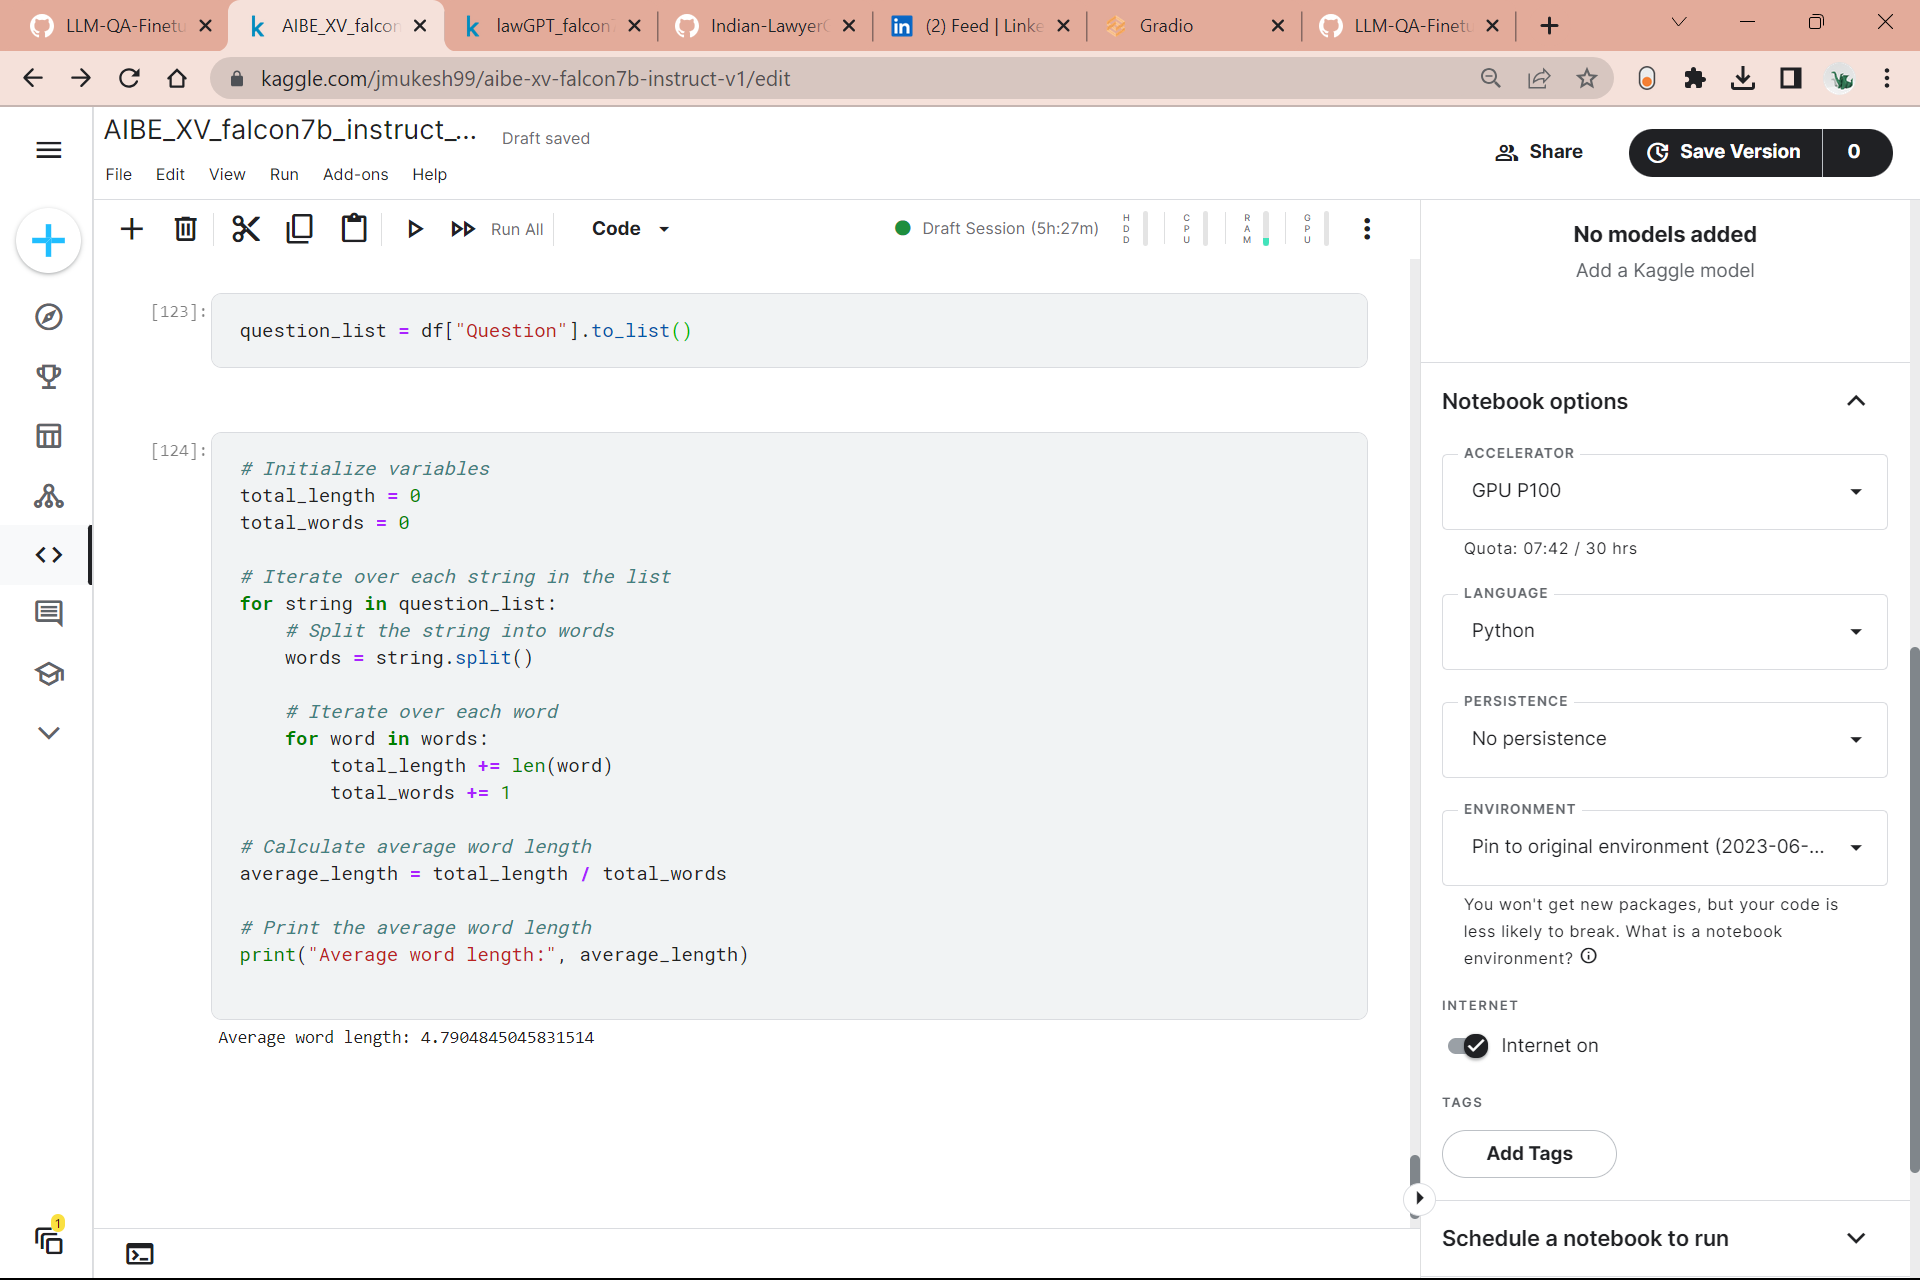